In [19]:
import pandas as pd
import csv
import os
import numpy as np
import glob
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import matplotlib.ticker as plticker

# Unificação dos outputs dos experimentos

In [2]:
#Vamos unificar todos os dataframes de resultados encontrados no path
def get_files(path, base, extension):
    """
    Descrição: Recebe um path e lista todos os arquivos e seta o extrator + tipo de augmentation
    Retorna um dataframe com todos os files concatenados de um determinado path
    """
    all_filenames = []
    df = pd.DataFrame()
    df_interno = pd.DataFrame()
    all_filenames = [i for i in glob.glob(path+'predicts-{}*.{}'.format(base, extension))]
    
    if(len(all_filenames) > 0):
        
        for f in all_filenames:
            
            #O nome do arquivo seguiu um padrão para ser gerado, por isso podemos aproveitar algumas infos
            df_interno = pd.read_csv(f, sep=";", index_col=None, usecols=['video_name', 'frame', 'aus'])
            
            extractor = f.split("s-")[-1].split('_')[0]
            df_interno['extractor'] = extractor
            
            if(extractor == 'mediapipe'):
                var_mp = f.split('_crop')[0].split("mediapipe_")[-1]
            elif(extractor == 'dlib'):
                var_mp = 'Não se aplica'
            df_interno['var_mp'] = var_mp
            
            crop = f.split("crop_")[-1].split('_')[0]
            df_interno['crop'] = crop
            
            factor = f.split("factor_")[-1].split('_')[0].replace('.csv', '')
            df_interno['factor'] = factor
            
            experiment = f.split("s-")[-1].replace('.csv', '')
            df_interno['experiment'] = experiment
            
            print(f.split("s-")[-1].replace('.csv', ''))

            df = pd.concat([df, df_interno], axis=0)
            
        return df


In [3]:
#Carregando o arquivo de ground truth
base='Videos-Tamires-Selecionados'
gd_truth = '../data/outputs/'+base+'/predicts_squeezenet/'+base+'-ground-truth.csv'
DF_GROUND_TRUTH = pd.read_csv(gd_truth, sep=";", index_col=None, usecols=['video_name', 'frame', 'ground truth'])
DF_GROUND_TRUTH.head(5)

,video_name,frame,ground truth
0,RostoIntensidade-04Quarta-Sortudo,1,0
1,RostoIntensidade-04Quarta-Sortudo,2,0
2,RostoIntensidade-04Quarta-Sortudo,3,0
3,RostoIntensidade-04Quarta-Sortudo,4,25+26+42
4,RostoIntensidade-04Quarta-Sortudo,5,25+26+42


In [4]:
path = '../data/outputs/'+base+'/predicts_squeezenet/'
extension = 'csv'

df = get_files(path, base, extension)
df.shape

mediapipe_posicao_crop_True_factor_005
dlib_crop_False_factor_115
dlib_crop_True_factor_115
mediapipe_posicao_crop_True_factor_0025
dlib_crop_True_factor_101
mediapipe_id_crop_True_factor_0
mediapipe_posicao_crop_False_factor_0
dlib_crop_False_factor_101
mediapipe_id_crop_True_factor_0025
mediapipe_id_crop_False_factor_0
mediapipe_id_crop_True_factor_005
mediapipe_posicao_crop_True_factor_0


(1596, 8)

In [5]:
df[['extractor', 'var_mp', 'crop', 'factor']].value_counts()

extractor  var_mp         crop   factor
dlib       Não se aplica  False  101       133
                                 115       133
                          True   101       133
                                 115       133
mediapipe  id             False  0         133
                          True   0         133
                                 0025      133
                                 005       133
           posicao        False  0         133
                          True   0         133
                                 0025      133
                                 005       133
dtype: int64

In [6]:
df.head(5)

,video_name,frame,aus,extractor,var_mp,crop,factor,experiment
0,RostoIntensidade-04Quarta-Aniquilar,1,0+10+17,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005
1,RostoIntensidade-04Quarta-Aniquilar,2,0+10+17,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005
2,RostoIntensidade-04Quarta-Aniquilar,3,0+10+17,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005
3,RostoIntensidade-04Quarta-Aniquilar,4,0+10+17,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005
4,RostoIntensidade-04Quarta-Aniquilar,5,0+10+17,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005


In [7]:
#Lista de unidades de ação passada por Emely
LABELS = [
    '0', '1', '2', '4', '5', '6', '7', '8', '9', 
    '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 
    '20', '21', '22', '23', '24', '25', '26', '27', '28', 
    '31', '32', '33', '34', '35', '36', '37', 
    '41', '42', '43', '44', '45', '46', 
    '50', '51', '52', '53', '54', '55', '56', '57', '58', 
    '61', '62', '63', '64', 
    '70', '71', '72', '73', 
    '81'
]

In [30]:
len(LABELS)

59

In [8]:
#Para cada frame, faça a busca do ground truth das unidades de ação
def get_ground_truth(video_name, frame):
    au_ground_truth = DF_GROUND_TRUTH.loc[(DF_GROUND_TRUTH['video_name']==video_name)
                                         & (DF_GROUND_TRUTH['frame']==frame)]
    print(au_ground_truth)
    if(len(au_ground_truth)==0):
        return '0'
    return au_ground_truth['ground truth'].item()


df['y_true'] = df.apply(lambda x: get_ground_truth(x.video_name, x.frame), axis=1)

                             video_name  frame ground truth
70  RostoIntensidade-04Quarta-Aniquilar      1            0
                             video_name  frame ground truth
71  RostoIntensidade-04Quarta-Aniquilar      2            0
                             video_name  frame ground truth
72  RostoIntensidade-04Quarta-Aniquilar      3            0
                             video_name  frame ground truth
73  RostoIntensidade-04Quarta-Aniquilar      4            4
                             video_name  frame ground truth
74  RostoIntensidade-04Quarta-Aniquilar      5            4
                             video_name  frame ground truth
75  RostoIntensidade-04Quarta-Aniquilar      6            4
                             video_name  frame ground truth
76  RostoIntensidade-04Quarta-Aniquilar      7      4+10+25
                             video_name  frame ground truth
77  RostoIntensidade-04Quarta-Aniquilar      8    4+9+10+25
                             video_name 

                             video_name  frame     ground truth
93  RostoIntensidade-04Quarta-Aniquilar     24  4+9+10+23+44+57
                             video_name  frame     ground truth
94  RostoIntensidade-04Quarta-Aniquilar     25  4+9+15+23+44+57
                             video_name  frame     ground truth
95  RostoIntensidade-04Quarta-Aniquilar     26  4+9+15+23+44+57
                             video_name  frame     ground truth
96  RostoIntensidade-04Quarta-Aniquilar     27  4+9+15+23+44+57
                             video_name  frame     ground truth
97  RostoIntensidade-04Quarta-Aniquilar     28  4+9+15+23+44+57
                             video_name  frame     ground truth
98  RostoIntensidade-04Quarta-Aniquilar     29  4+9+15+23+44+57
                             video_name  frame     ground truth
99  RostoIntensidade-04Quarta-Aniquilar     30  4+9+15+23+44+57
                              video_name  frame     ground truth
100  RostoIntensidade-04Quarta-Aniquila

69  RostoIntensidade-04Quarta-Sortudo     70     12+42+51
Empty DataFrame
Columns: [video_name, frame, ground truth]
Index: []
                             video_name  frame ground truth
70  RostoIntensidade-04Quarta-Aniquilar      1            0
                             video_name  frame ground truth
71  RostoIntensidade-04Quarta-Aniquilar      2            0
                             video_name  frame ground truth
72  RostoIntensidade-04Quarta-Aniquilar      3            0
                             video_name  frame ground truth
73  RostoIntensidade-04Quarta-Aniquilar      4            4
                             video_name  frame ground truth
74  RostoIntensidade-04Quarta-Aniquilar      5            4
                             video_name  frame ground truth
75  RostoIntensidade-04Quarta-Aniquilar      6            4
                             video_name  frame ground truth
76  RostoIntensidade-04Quarta-Aniquilar      7      4+10+25
                             vide

56  RostoIntensidade-04Quarta-Sortudo     57     12+42+51
                           video_name  frame ground truth
57  RostoIntensidade-04Quarta-Sortudo     58     12+42+51
                           video_name  frame ground truth
58  RostoIntensidade-04Quarta-Sortudo     59     12+42+51
                           video_name  frame ground truth
59  RostoIntensidade-04Quarta-Sortudo     60     12+42+51
                           video_name  frame ground truth
60  RostoIntensidade-04Quarta-Sortudo     61     12+42+51
                           video_name  frame ground truth
61  RostoIntensidade-04Quarta-Sortudo     62     12+42+51
                           video_name  frame ground truth
62  RostoIntensidade-04Quarta-Sortudo     63     12+42+51
                           video_name  frame ground truth
63  RostoIntensidade-04Quarta-Sortudo     64     12+42+51
                           video_name  frame ground truth
64  RostoIntensidade-04Quarta-Sortudo     65     12+42+51
              

34  RostoIntensidade-04Quarta-Sortudo     35     13+42+51
                           video_name  frame ground truth
35  RostoIntensidade-04Quarta-Sortudo     36     12+42+51
                           video_name  frame ground truth
36  RostoIntensidade-04Quarta-Sortudo     37     12+42+51
                           video_name  frame ground truth
37  RostoIntensidade-04Quarta-Sortudo     38  12+42+51+53
                           video_name  frame ground truth
38  RostoIntensidade-04Quarta-Sortudo     39  12+42+51+53
                           video_name  frame ground truth
39  RostoIntensidade-04Quarta-Sortudo     40  12+42+51+53
                           video_name  frame ground truth
40  RostoIntensidade-04Quarta-Sortudo     41  12+42+51+53
                           video_name  frame ground truth
41  RostoIntensidade-04Quarta-Sortudo     42  12+42+51+53
                           video_name  frame ground truth
42  RostoIntensidade-04Quarta-Sortudo     43  12+42+51+53
              

24  RostoIntensidade-04Quarta-Sortudo     25     13+43+51
                           video_name  frame ground truth
25  RostoIntensidade-04Quarta-Sortudo     26     13+43+51
                           video_name  frame ground truth
26  RostoIntensidade-04Quarta-Sortudo     27     13+42+51
                           video_name  frame ground truth
27  RostoIntensidade-04Quarta-Sortudo     28     13+42+51
                           video_name  frame ground truth
28  RostoIntensidade-04Quarta-Sortudo     29     13+42+51
                           video_name  frame ground truth
29  RostoIntensidade-04Quarta-Sortudo     30     13+42+51
                           video_name  frame ground truth
30  RostoIntensidade-04Quarta-Sortudo     31     13+42+51
                           video_name  frame ground truth
31  RostoIntensidade-04Quarta-Sortudo     32     13+42+51
                           video_name  frame ground truth
32  RostoIntensidade-04Quarta-Sortudo     33     13+42+51
              

4  RostoIntensidade-04Quarta-Sortudo      5     25+26+42
                          video_name  frame ground truth
5  RostoIntensidade-04Quarta-Sortudo      6     25+26+42
                          video_name  frame ground truth
6  RostoIntensidade-04Quarta-Sortudo      7  25+26+42+51
                          video_name  frame ground truth
7  RostoIntensidade-04Quarta-Sortudo      8  25+26+42+51
                          video_name  frame ground truth
8  RostoIntensidade-04Quarta-Sortudo      9  25+26+42+51
                          video_name  frame ground truth
9  RostoIntensidade-04Quarta-Sortudo     10  25+26+42+51
                           video_name  frame    ground truth
10  RostoIntensidade-04Quarta-Sortudo     11  22+25+26+42+51
                           video_name  frame    ground truth
11  RostoIntensidade-04Quarta-Sortudo     12  22+25+26+42+51
                           video_name  frame    ground truth
12  RostoIntensidade-04Quarta-Sortudo     13  22+25+26+42+51
       

130  RostoIntensidade-04Quarta-Aniquilar     61            0
Empty DataFrame
Columns: [video_name, frame, ground truth]
Index: []
                          video_name  frame ground truth
0  RostoIntensidade-04Quarta-Sortudo      1            0
                          video_name  frame ground truth
1  RostoIntensidade-04Quarta-Sortudo      2            0
                          video_name  frame ground truth
2  RostoIntensidade-04Quarta-Sortudo      3            0
                          video_name  frame ground truth
3  RostoIntensidade-04Quarta-Sortudo      4     25+26+42
                          video_name  frame ground truth
4  RostoIntensidade-04Quarta-Sortudo      5     25+26+42
                          video_name  frame ground truth
5  RostoIntensidade-04Quarta-Sortudo      6     25+26+42
                          video_name  frame ground truth
6  RostoIntensidade-04Quarta-Sortudo      7  25+26+42+51
                          video_name  frame ground truth
7  RostoIntensi

                              video_name  frame     ground truth
106  RostoIntensidade-04Quarta-Aniquilar     37  4+9+15+23+44+57
                              video_name  frame        ground truth
107  RostoIntensidade-04Quarta-Aniquilar     38  4+9+15+17+23+44+57
                              video_name  frame        ground truth
108  RostoIntensidade-04Quarta-Aniquilar     39  4+9+15+17+23+44+57
                              video_name  frame        ground truth
109  RostoIntensidade-04Quarta-Aniquilar     40  4+9+15+17+23+44+57
                              video_name  frame        ground truth
110  RostoIntensidade-04Quarta-Aniquilar     41  4+9+15+17+23+44+57
                              video_name  frame        ground truth
111  RostoIntensidade-04Quarta-Aniquilar     42  4+9+15+17+23+44+57
                              video_name  frame ground truth
112  RostoIntensidade-04Quarta-Aniquilar     43      4+23+44
                              video_name  frame ground truth
113  Ro

                             video_name  frame     ground truth
98  RostoIntensidade-04Quarta-Aniquilar     29  4+9+15+23+44+57
                             video_name  frame     ground truth
99  RostoIntensidade-04Quarta-Aniquilar     30  4+9+15+23+44+57
                              video_name  frame     ground truth
100  RostoIntensidade-04Quarta-Aniquilar     31  4+9+15+23+44+57
                              video_name  frame     ground truth
101  RostoIntensidade-04Quarta-Aniquilar     32  4+9+15+23+44+57
                              video_name  frame     ground truth
102  RostoIntensidade-04Quarta-Aniquilar     33  4+9+15+23+44+57
                              video_name  frame     ground truth
103  RostoIntensidade-04Quarta-Aniquilar     34  4+9+15+23+44+57
                              video_name  frame     ground truth
104  RostoIntensidade-04Quarta-Aniquilar     35  4+9+15+23+44+57
                              video_name  frame     ground truth
105  RostoIntensidade-04Quart

78  RostoIntensidade-04Quarta-Aniquilar      9    4+9+10+25
                             video_name  frame  ground truth
79  RostoIntensidade-04Quarta-Aniquilar     10  4+9+10+25+26
                             video_name  frame  ground truth
80  RostoIntensidade-04Quarta-Aniquilar     11  4+9+10+25+26
                             video_name  frame  ground truth
81  RostoIntensidade-04Quarta-Aniquilar     12  4+9+10+25+26
                             video_name  frame  ground truth
82  RostoIntensidade-04Quarta-Aniquilar     13  4+9+25+26+44
                             video_name  frame     ground truth
83  RostoIntensidade-04Quarta-Aniquilar     14  4+9+22+25+26+44
                             video_name  frame     ground truth
84  RostoIntensidade-04Quarta-Aniquilar     15  4+9+22+25+26+44
                             video_name  frame     ground truth
85  RostoIntensidade-04Quarta-Aniquilar     16  4+9+22+25+26+44
                             video_name  frame     ground truth
86  

70  RostoIntensidade-04Quarta-Aniquilar      1            0
                             video_name  frame ground truth
71  RostoIntensidade-04Quarta-Aniquilar      2            0
                             video_name  frame ground truth
72  RostoIntensidade-04Quarta-Aniquilar      3            0
                             video_name  frame ground truth
73  RostoIntensidade-04Quarta-Aniquilar      4            4
                             video_name  frame ground truth
74  RostoIntensidade-04Quarta-Aniquilar      5            4
                             video_name  frame ground truth
75  RostoIntensidade-04Quarta-Aniquilar      6            4
                             video_name  frame ground truth
76  RostoIntensidade-04Quarta-Aniquilar      7      4+10+25
                             video_name  frame ground truth
77  RostoIntensidade-04Quarta-Aniquilar      8    4+9+10+25
                             video_name  frame ground truth
78  RostoIntensidade-04Quarta-Aniquilar 

49  RostoIntensidade-04Quarta-Sortudo     50  12+42+51+53
                           video_name  frame ground truth
50  RostoIntensidade-04Quarta-Sortudo     51  12+42+51+53
                           video_name  frame ground truth
51  RostoIntensidade-04Quarta-Sortudo     52  12+42+51+53
                           video_name  frame ground truth
52  RostoIntensidade-04Quarta-Sortudo     53     12+42+51
                           video_name  frame ground truth
53  RostoIntensidade-04Quarta-Sortudo     54     12+42+51
                           video_name  frame ground truth
54  RostoIntensidade-04Quarta-Sortudo     55     12+42+51
                           video_name  frame ground truth
55  RostoIntensidade-04Quarta-Sortudo     56     12+42+51
                           video_name  frame ground truth
56  RostoIntensidade-04Quarta-Sortudo     57     12+42+51
                           video_name  frame ground truth
57  RostoIntensidade-04Quarta-Sortudo     58     12+42+51
              

38  RostoIntensidade-04Quarta-Sortudo     39  12+42+51+53
                           video_name  frame ground truth
39  RostoIntensidade-04Quarta-Sortudo     40  12+42+51+53
                           video_name  frame ground truth
40  RostoIntensidade-04Quarta-Sortudo     41  12+42+51+53
                           video_name  frame ground truth
41  RostoIntensidade-04Quarta-Sortudo     42  12+42+51+53
                           video_name  frame ground truth
42  RostoIntensidade-04Quarta-Sortudo     43  12+42+51+53
                           video_name  frame ground truth
43  RostoIntensidade-04Quarta-Sortudo     44  12+42+51+53
                           video_name  frame ground truth
44  RostoIntensidade-04Quarta-Sortudo     45  12+42+51+53
                           video_name  frame ground truth
45  RostoIntensidade-04Quarta-Sortudo     46  12+42+51+53
                           video_name  frame ground truth
46  RostoIntensidade-04Quarta-Sortudo     47  12+42+51+53
              

In [9]:
df.head(10)

,video_name,frame,aus,extractor,var_mp,crop,factor,experiment,y_true
0,RostoIntensidade-04Quarta-Aniquilar,1,0+10+17,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005,0
1,RostoIntensidade-04Quarta-Aniquilar,2,0+10+17,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005,0
2,RostoIntensidade-04Quarta-Aniquilar,3,0+10+17,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005,0
3,RostoIntensidade-04Quarta-Aniquilar,4,0+10+17,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005,4
4,RostoIntensidade-04Quarta-Aniquilar,5,0+10+17,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005,4
5,RostoIntensidade-04Quarta-Aniquilar,6,0+10+17,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005,4
6,RostoIntensidade-04Quarta-Aniquilar,7,0+10+17,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005,4+10+25
7,RostoIntensidade-04Quarta-Aniquilar,8,0+10+17,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005,4+9+10+25
8,RostoIntensidade-04Quarta-Aniquilar,9,0+10+17,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005,4+9+10+25
9,RostoIntensidade-04Quarta-Aniquilar,10,0+10+17,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005,4+9+10+25+26


In [10]:
def search(element, data):
    retorno = 0
    
    if(element in data):
        retorno = 1
    
    return retorno


def dict_generate(df_temp, data):
    thisdict = {}

    for c in df_temp.columns:
        thisdict[c] = search(c, data)

    return thisdict 


def generate_vector_y(y_true, y_pred):
    
    #Criando uma lista com todas as unidades de ação
    y_pred = y_pred.split('+')
    y_true = y_true.split('+')
    
    #Criando um dataframe com colunas fixas, as colunas são as unidades de ação
    df_pred = pd.DataFrame(columns=LABELS)
    df_true = pd.DataFrame(columns=LABELS)
    
    #Gerando um dicionário de forma que para cada chave (unidade de ação) tenha 
    #   o valor 1 para indicar presença dessa unidade de ação e 0 para ausência.
    dict_y_pred = dict_generate(df_pred, y_pred)
    dict_y_true = dict_generate(df_true, y_true)
    
    #Criando uma lista dos valores das chaves dos dicionários
    y_pred = list(dict_y_pred.values())
    y_true = list(dict_y_true.values())
    
    return y_true, y_pred


def generate_acc(y_true, y_pred):
    y_true_formated, y_pred_formated = generate_vector_y(y_true, y_pred)
    return accuracy_score(y_true_formated, y_pred_formated)

def generate_precision(y_true, y_pred):
    y_true_formated, y_pred_formated = generate_vector_y(y_true, y_pred)
    return precision_score(y_true_formated, y_pred_formated, labels=[1], average='micro')

def generate_recall(y_true, y_pred):
    y_true_formated, y_pred_formated = generate_vector_y(y_true, y_pred)
    return recall_score(y_true_formated, y_pred_formated, labels=[1], average='micro')

def generate_f1(y_true, y_pred):
    y_true_formated, y_pred_formated = generate_vector_y(y_true, y_pred)
    return f1_score(y_true_formated, y_pred_formated, labels=[1], average='micro')
    

## Geração das métricas

In [11]:
df['acc'] = df.apply(lambda x: generate_acc(x.y_true, x.aus), axis=1)
df['precision'] = df.apply(lambda x: generate_precision(x.y_true, x.aus), axis=1)
df['recall'] = df.apply(lambda x: generate_recall(x.y_true, x.aus), axis=1)
df['f1'] = df.apply(lambda x: generate_f1(x.y_true, x.aus), axis=1)


In [12]:
df[100:110]

,video_name,frame,aus,extractor,var_mp,crop,factor,experiment,y_true,acc,precision,recall,f1
100,RostoIntensidade-04Quarta-Sortudo,39,0+12+17+20,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005,12+42+51+53,0.898305,0.25,0.25,0.25
101,RostoIntensidade-04Quarta-Sortudo,40,0+12+17+20,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005,12+42+51+53,0.898305,0.25,0.25,0.25
102,RostoIntensidade-04Quarta-Sortudo,41,0+12+17+20,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005,12+42+51+53,0.898305,0.25,0.25,0.25
103,RostoIntensidade-04Quarta-Sortudo,42,0+12+17+20,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005,12+42+51+53,0.898305,0.25,0.25,0.25
104,RostoIntensidade-04Quarta-Sortudo,43,0+12+17+20,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005,12+42+51+53,0.898305,0.25,0.25,0.25
105,RostoIntensidade-04Quarta-Sortudo,44,0+12+17+20,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005,12+42+51+53,0.898305,0.25,0.25,0.25
106,RostoIntensidade-04Quarta-Sortudo,45,0+12+17+20,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005,12+42+51+53,0.898305,0.25,0.25,0.25
107,RostoIntensidade-04Quarta-Sortudo,46,0+12+17+20,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005,12+42+51+53,0.898305,0.25,0.25,0.25
108,RostoIntensidade-04Quarta-Sortudo,47,0+12+17+20,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005,12+42+51+53,0.898305,0.25,0.25,0.25
109,RostoIntensidade-04Quarta-Sortudo,48,0+12+17+20,mediapipe,posicao,True,005,mediapipe_posicao_crop_True_factor_005,12+42+51+53,0.898305,0.25,0.25,0.25


# Avaliação dos resultados por experimento

In [13]:
df.groupby(['extractor', 'var_mp', 'crop', 'factor']).agg(['mean', 'median'])

frame              acc            \
                                           mean median      mean    median   
extractor var_mp        crop  factor                                         
dlib      Não se aplica False 101     33.902256   34.0  0.893208  0.898305   
                              115     33.902256   34.0  0.893208  0.898305   
                        True  101     33.902256   34.0  0.888492  0.898305   
                              115     33.902256   34.0  0.900344  0.915254   
mediapipe id            False 0       33.902256   34.0  0.893208  0.898305   
                        True  0       33.902256   34.0  0.894609  0.898305   
                              0025    33.902256   34.0  0.894737  0.898305   
                              005     33.902256   34.0  0.894355  0.898305   
          posicao       False 0       33.902256   34.0  0.893208  0.898305   
                        True  0       33.902256   34.0  0.894609  0.898305   
                              0025    33.902256   34.0  0.894737  0.898305   
                              005     33.902256   34.0  0.894355  0.898305   

                                     precision           recall            \
                                          mean median      mean    median   
extractor var_mp        crop  factor                                        
dlib      Não se aplica False 101     0.149749   0.25  0.161511  0.142857   
                              115     0.149749   0.25  0.161511  0.142857   
                        True  101     0.103634   0.00  0.122431  0.000000   
                              115     0.117168   0.00  0.134443  0.000000   
mediapipe id            False 0       0.149749   0.25  0.161511  0.142857   
                        True  0       0.141604   0.00  0.219245  0.000000   
                              0025    0.138471   0.00  0.207161  0.000000   
                              005     0.140351   0.00  0.218528  0.000000   
          posicao       False 0       0.149749   0.25  0.161511  0.142857   
                        True  0       0.141604   0.00  0.219245  0.000000   
                              0025    0.138471   0.00  0.207161  0.000000   
                              005     0.140351   0.00  0.218528  0.000000   

                                            f1         
                                          mean median  
extractor var_mp        crop  factor                   
dlib      Não se aplica False 101     0.143419    0.2  
                              115     0.143419    0.2  
                        True  101     0.107244    0.0  
                              115     0.117854    0.0  
mediapipe id            False 0       0.143419    0.2  
                        True  0       0.156118    0.0  
                              0025    0.149033    0.0  
                              005     0.156666    0.0  
          posicao       False 0       0.143419    0.2  
                        True  0       0.156118    0.0  
                              0025    0.149033    0.0  
                              005     0.156666    0.0

In [14]:
dd = df.groupby(['extractor', 'var_mp', 'crop', 'factor'], as_index=False ).agg(['mean', 'median'])
dd.columns = list(map('_'.join, dd.columns.values))
dg = dd.reset_index()[['extractor', 'var_mp', 'crop', 'factor', 
                       'acc_mean', 'precision_mean',
                       'recall_mean', 'f1_mean']]
dg

,extractor,var_mp,crop,factor,acc_mean,precision_mean,recall_mean,f1_mean
0,dlib,Não se aplica,False,101,0.893208,0.149749,0.161511,0.143419
1,dlib,Não se aplica,False,115,0.893208,0.149749,0.161511,0.143419
2,dlib,Não se aplica,True,101,0.888492,0.103634,0.122431,0.107244
3,dlib,Não se aplica,True,115,0.900344,0.117168,0.134443,0.117854
4,mediapipe,id,False,0,0.893208,0.149749,0.161511,0.143419
5,mediapipe,id,True,0,0.894609,0.141604,0.219245,0.156118
6,mediapipe,id,True,0025,0.894737,0.138471,0.207161,0.149033
7,mediapipe,id,True,005,0.894355,0.140351,0.218528,0.156666
8,mediapipe,posicao,False,0,0.893208,0.149749,0.161511,0.143419
9,mediapipe,posicao,True,0,0.894609,0.141604,0.219245,0.156118


In [15]:
dg = dg.loc[dg.var_mp != 'posicao'][['extractor', 'crop', 'factor', 
                       'acc_mean', 'precision_mean',
                       'recall_mean', 'f1_mean']]
dg

,extractor,crop,factor,acc_mean,precision_mean,recall_mean,f1_mean
0,dlib,False,101,0.893208,0.149749,0.161511,0.143419
1,dlib,False,115,0.893208,0.149749,0.161511,0.143419
2,dlib,True,101,0.888492,0.103634,0.122431,0.107244
3,dlib,True,115,0.900344,0.117168,0.134443,0.117854
4,mediapipe,False,0,0.893208,0.149749,0.161511,0.143419
5,mediapipe,True,0,0.894609,0.141604,0.219245,0.156118
6,mediapipe,True,0025,0.894737,0.138471,0.207161,0.149033
7,mediapipe,True,005,0.894355,0.140351,0.218528,0.156666


### Impacto do Crop no Dlib

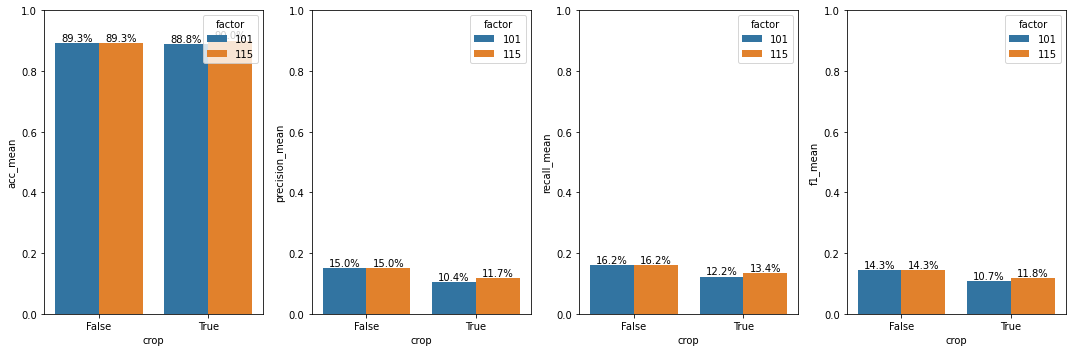

In [20]:
# Dlib

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
ax = sns.barplot(x="crop", y="acc_mean", hue="factor", data=dg.loc[dg.extractor == 'dlib'])
custom_ylim =  (0, 1)
for c in ax.containers:
        labels = [f'{v.get_height()*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
plt.setp(ax, ylim=custom_ylim)
        

plt.subplot(1, 4, 2)
ax = sns.barplot(x="crop", y="precision_mean", hue="factor", data=dg.loc[dg.extractor == 'dlib'])
custom_ylim =  (0, 1)
for c in ax.containers:
        labels = [f'{v.get_height()*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
plt.setp(ax, ylim=custom_ylim)

plt.subplot(1, 4, 3)
ax = sns.barplot(x="crop", y="recall_mean", hue="factor", data=dg.loc[dg.extractor == 'dlib'])
custom_ylim =  (0, 1)
for c in ax.containers:
        labels = [f'{v.get_height()*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
plt.setp(ax, ylim=custom_ylim)

plt.subplot(1, 4, 4)
ax = sns.barplot(x="crop", y="f1_mean", hue="factor", data=dg.loc[dg.extractor == 'dlib'])
custom_ylim =  (0, 1)
for c in ax.containers:
        labels = [f'{v.get_height()*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
plt.setp(ax, ylim=custom_ylim)

plt.tight_layout()
plt.show()

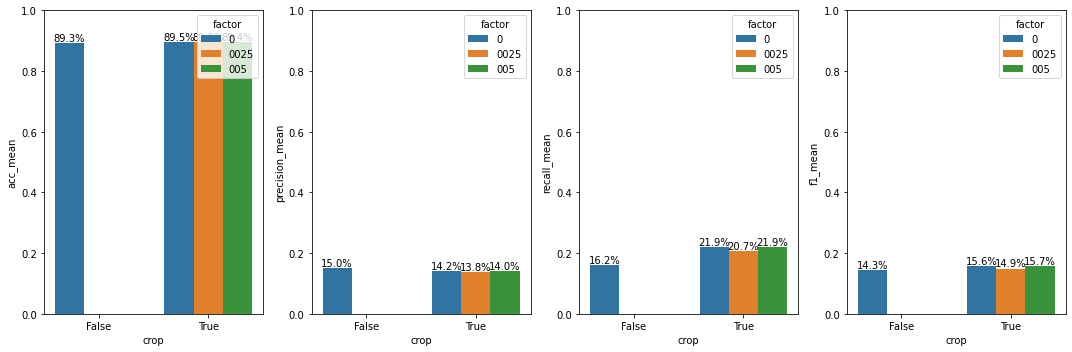

In [21]:
# Mediapipe

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
ax = sns.barplot(x="crop", y="acc_mean", hue="factor", data=dg.loc[dg.extractor == 'mediapipe'])
custom_ylim =  (0, 1)
for c in ax.containers:
        labels = [f'{v.get_height()*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
plt.setp(ax, ylim=custom_ylim)

plt.subplot(1, 4, 2)
ax = sns.barplot(x="crop", y="precision_mean", hue="factor", data=dg.loc[dg.extractor == 'mediapipe'])
custom_ylim =  (0, 1)
for c in ax.containers:
        labels = [f'{v.get_height()*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
plt.setp(ax, ylim=custom_ylim)

plt.subplot(1, 4, 3)
ax = sns.barplot(x="crop", y="recall_mean", hue="factor", data=dg.loc[dg.extractor == 'mediapipe'])
custom_ylim =  (0, 1)
for c in ax.containers:
        labels = [f'{v.get_height()*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
plt.setp(ax, ylim=custom_ylim)

plt.subplot(1, 4, 4)
ax = sns.barplot(x="crop", y="f1_mean", hue="factor", data=dg.loc[dg.extractor == 'mediapipe'])
custom_ylim =  (0, 1)
for c in ax.containers:
        labels = [f'{v.get_height()*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
plt.setp(ax, ylim=custom_ylim)

plt.tight_layout()
plt.show()

### Há diferença significativa entre os experimentos? 


In [23]:
data_stats = pd.pivot(df[['experiment', 'f1']].loc[df.var_mp != 'posicao'], values = 'f1', columns = 'experiment')
data_stats

experiment,dlib_crop_False_factor_101,dlib_crop_False_factor_115,dlib_crop_True_factor_101,dlib_crop_True_factor_115,mediapipe_id_crop_False_factor_0,mediapipe_id_crop_True_factor_0,mediapipe_id_crop_True_factor_0025,mediapipe_id_crop_True_factor_005
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.500000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.500000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.500000
3,0.400000,0.400000,0.500000,0.500000,0.400000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
128,0.285714,0.285714,0.285714,0.285714,0.285714,0.000000,0.285714,0.285714
129,0.285714,0.285714,0.285714,0.285714,0.285714,0.285714,0.285714,0.285714
130,0.285714,0.285714,0.285714,0.285714,0.285714,0.000000,0.285714,0.285714
131,0.000000,0.000000,0.285714,0.285714,0.000000,0.000000,0.000000,0.000000


In [24]:
data_stats.columns

Index(['dlib_crop_False_factor_101', 'dlib_crop_False_factor_115',
       'dlib_crop_True_factor_101', 'dlib_crop_True_factor_115',
       'mediapipe_id_crop_False_factor_0', 'mediapipe_id_crop_True_factor_0',
       'mediapipe_id_crop_True_factor_0025',
       'mediapipe_id_crop_True_factor_005'],
      dtype='object', name='experiment')

In [25]:
data_stats = data_stats.rename(columns={
    'dlib_crop_False_factor_101': 'DF101', 
    'dlib_crop_False_factor_115': 'DF115',
    'dlib_crop_True_factor_101': 'DT101', 
    'dlib_crop_True_factor_115': 'DT115',
    'mediapipe_id_crop_False_factor_0' :'MF0', 
    'mediapipe_id_crop_True_factor_0': 'MT0',
    'mediapipe_id_crop_True_factor_0025': 'MT25',
    'mediapipe_id_crop_True_factor_005': 'MT50'
    
})

data_stats = data_stats[['DT115', 'DT101', 'DF101', 'DF115', 'MF0', 'MT0', 'MT25', 'MT50']]
data_stats

experiment,DT115,DT101,DF101,DF115,MF0,MT0,MT25,MT50
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.500000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.500000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.500000
3,0.500000,0.500000,0.400000,0.400000,0.400000,0.000000,0.000000,0.000000
4,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
128,0.285714,0.285714,0.285714,0.285714,0.285714,0.000000,0.285714,0.285714
129,0.285714,0.285714,0.285714,0.285714,0.285714,0.285714,0.285714,0.285714
130,0.285714,0.285714,0.285714,0.285714,0.285714,0.000000,0.285714,0.285714
131,0.285714,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [26]:
data_stats = data_stats*100

In [27]:
data_stats.to_csv("../data/outputs/Videos-Tamires-Selecionados/predicts_squeezenet/f1_estimation_stats.csv", sep=',', index=False)

array([[<AxesSubplot:title={'center':'DT115'}>,
        <AxesSubplot:title={'center':'DT101'}>,
        <AxesSubplot:title={'center':'DF101'}>],
       [<AxesSubplot:title={'center':'DF115'}>,
        <AxesSubplot:title={'center':'MF0'}>,
        <AxesSubplot:title={'center':'MT0'}>],
       [<AxesSubplot:title={'center':'MT25'}>,
        <AxesSubplot:title={'center':'MT50'}>, <AxesSubplot:>]],
      dtype=object)

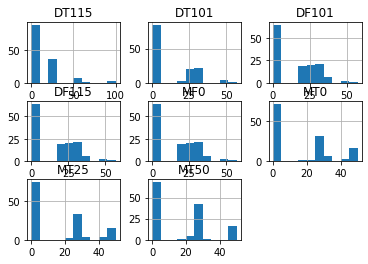

In [28]:
data_stats.hist()

<AxesSubplot:xlabel='DT101', ylabel='Count'>

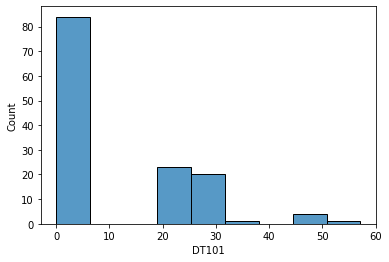

In [29]:
sns.histplot(data=data_stats, x="DT101")

In [16]:
FIM

NameError: name 'FIM' is not defined

In [ ]:
df.extractor.unique()

In [ ]:
df.var_mp.unique()

In [ ]:
for i in df.var_mp.unique():
    print(i)
    data = df.loc[df.var_mp == i]

In [ ]:
df.loc[(df.extractor == 'dlib') & (df.crop == 'False')].shape

In [ ]:
df.loc[(df.var_mp == 'Não se aplica') & (df.crop == 'True') & (df.factor == '115')].shape

In [ ]:
df.loc[(df.var_mp == 'id') & (df.crop == 'True') & (df.factor == '0')].shape

In [ ]:
df.loc[(df.var_mp == 'posicao') & (df.crop == 'True') & (df.factor == '0')].shape

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.xticks(())
plt.yticks(())
plt.text(0.5, 0.5, 'subplot(1,2,1)', ha='center', va='center',
        size=24, alpha=.5)

plt.subplot(1, 4, 2)
plt.xticks(())
plt.yticks(())
plt.text(0.5, 0.5, 'subplot(1,2,2)', ha='center', va='center',
        size=24, alpha=.5)

plt.subplot(1, 4, 3)
plt.xticks(())
plt.yticks(())
plt.text(0.5, 0.5, 'subplot(1,2,2)', ha='center', va='center',
        size=24, alpha=.5)

plt.subplot(1, 4, 4)
plt.xticks(())
plt.yticks(())
plt.text(0.5, 0.5, 'subplot(1,2,2)', ha='center', va='center',
        size=24, alpha=.5)

plt.tight_layout()
plt.show()

In [ ]:
crop == True
    factor == '005'

In [ ]:
fig = plt.figure(figsize=(14,8))
ax = sns.countplot(x="aug", hue="extractor", data=df, palette=colors)

In [ ]:
def plt_bar_extract_na(df_combined, na):
    fig = plt.figure(figsize=(14,8))
    count = 1
    colors = ['green', "red", 'blue']

    df = df_combined.loc[(df_combined['na'] == na)].reset_index()
    ax = sns.countplot(x="aug", hue="extractor", data=df, palette=colors)
    ax.set(ylabel='Total of Frames', title='Quantidade de frames com landmarks retornados (%)')
    idx_extractor=0
    for c in ax.containers:
        qt_extractores = len(df_combined.extractor.unique())
        qt_aug = len(df_combined.aug.unique())
        
        #labels = [f'{w/len(df.index)*len(df.aug.unique())*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        labels = [f'{w/((len(df_combined)/qt_extractores)/qt_aug)*100:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
        idx_extractor=idx_extractor+1
        
    plt.xticks(rotation=20)
    
    
plt_bar_extract_na(df_combined,  0)

In [ ]:
FIM

In [ ]:
data = '4+42+12+17+20+1'
data = data.split('+')
print(data)

print(search('42', data))
print(search('43', data))

In [ ]:
df_temp = pd.DataFrame(columns=LABELS)
thisdict = dict_generate(df_temp, data)
print(thisdict)

In [ ]:
df_temp = df_temp.append(thisdict, ignore_index=True)
df_temp

In [ ]:

u = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
v = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

accuracy_score(u, v)

In [ ]:


u = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
v = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

recall_score(u, v,labels=[1], average='micro')

In [ ]:


u = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
v = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

precision_score(u, v,labels=[1], average='micro')

In [ ]:


u = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
v = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

f1_score(u, v,labels=[1], average='micro')

In [ ]:



columns = np.unique(u)

confm = confusion_matrix(u, v)
df_cm = pd.DataFrame(confm, index=columns, columns=columns)

ax = sn.heatmap(df_cm, cmap='Oranges', annot=True)

In [ ]:
"""path = "../data/outputs/Videos-Emely-Extra/predicts_squeezenet/Videos-Emely-Extra-comparison3-predicts.csv"
df = pd.read_csv(path, sep=';', usecols=['video_name',
                                         'end',
                                         'frame',
                                         'start',
                                         'ground truth',
                                         'aus dlib115',
                                         'aus dlib101',
                                         'aus mediapipe',
                                         'aus dlib115 sem crop'])
df"""

In [ ]:
def patk(real, pred, k):
    #we return 0 if k is 0 because 
    #   we can't divide the no of common values by 0 
    if k == 0:
        return 0

    #taking only the top k predictions in a class 
    k_pred = pred[:k]

    #taking the set of the actual values 
    real_set = set(real)

    #taking the set of the predicted values 
    pred_set = set(k_pred)

    #taking the intersection of the actual set and the pred set
        # to find the common values
    common_values = real_set.intersection(pred_set)
    
    return len(common_values)/len(pred[:k])

In [ ]:
#defining the values of the actual and the predicted class
y_true = [1 ,2, 0]
y_pred = [1, 1, 0]


print(patk(y_true, y_pred,3))

In [ ]:
def acc(real, pred):
    real = set(real.split('+'))
    pred = set(pred.split('+'))
    z = real.intersection(pred)
    return len(z)/len(real)

In [ ]:
real = '1+2+25+27'
pred = '4+42+12+17+20+1'
print(acc(real, pred))

In [ ]:
print(patk(y_true, y_pred,3))

In [ ]:
x = '1+2+25+27'
pred = '4+42+12+17+20+1'

x = set(x.split('+'))
pred = set(pred.split('+'))

In [ ]:
z = x.intersection(pred)

print(z)

In [ ]:
len(z)/len(x)

In [ ]:
tp = 1
tn = 
fn = 
fp =

In [ ]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
acc = (tp+tn)/(tp+fp+fn+tn)

In [ ]:
df_ground_truth.head(25)

In [ ]:
for i, j in enumerate(range(0, 20)):
    print(j)